# ДЗ 4. Generative adversarial networks

Используя файл Web4.ipynb нужно обучить генератор создавать точки, которые будут лежать на графике функции
y = sin(x)/x - x/10  
При выполнении данного задания структура GAN остается той же, но Вам нужно:  

- Сгенерировать настоящие данные  
- Изменить архитектуру дискриминатора и генератора  
- Построить графики  

## Библиотеки и скрипты

In [1]:
import numpy as np
import os, math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

from IPython import display
from torchvision.utils import save_image, make_grid

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu'
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers

        self.model = nn.Sequential(
            # input 64x2
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        pred = self.model(z)
        return pred
    
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        nn.init.uniform_(self.weights, -0.5, 0.5) 
        nn.init.uniform_(self.bias, -0.5, 0.5)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pred):
        validity = self.model(pred)

        return validity

## Генерируем данные

In [4]:
x = torch.linspace(-30, 30, 1000)
def func_y(x):
    return np.sin(x)/x - x/10

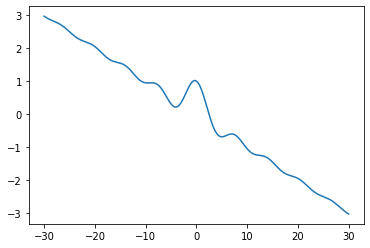

In [5]:
plt.plot(x, func_y(x))
plt.show()

## Обучаем генератор и дискриминатор

In [6]:
n_epochs = 35
batch_size = 32
lr = 0.0005

b1 = 0.5
b2 = 0.999

latent_dim = 1000

n_classes = 10
img_size = 28
channels = 1
sample_interval = 25

In [7]:
x_y_data = np.array([(x_i, func_y(x_i)) for x_i in x])

real_data = torch.utils.data.DataLoader(
    x_y_data,
    batch_size=batch_size,
    shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

[Epoch 34/35] [Batch 12/32] [D loss: 0.772115] [G loss: 1.336214]


<Figure size 432x288 with 0 Axes>

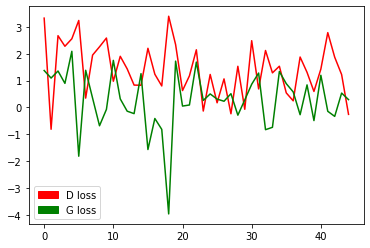

In [8]:
d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_ex = Variable(data.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)

        gen_ex = generator(z)

        validity = discriminator(gen_ex)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_ex)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_ex.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [9]:
generator.eval()

test_z = Variable(torch.from_numpy(np.random.uniform(-30, 30, (64, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

In [10]:
cnt = 0
error = 0.0
count = 0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = func_y(x)  
    y_pred = test_pred[i][1]  
    count +=1
    error += abs(y_real - y_pred)

print("Mean error: %.10f" % (error/count))

Mean error: 0.1116531715


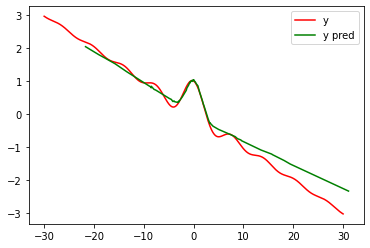

In [11]:
plt.figure()

x = np.linspace(-30, 30, 1000)
plt.plot(x, func_y(x), label='y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.show()